In [1]:
pip install wrds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [2]:
import pandas as pd
import wrds
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd, YearEnd
import pandas_datareader
import os
from datetime import datetime

In [3]:
# WRDS login information
data_folder = 'Data/'  # folder where we'll keep your data
id_wrds = 'mjgarciagomez'  # add your own wrds id, e.g. id_wrds = 'skywalker'

# Share codes and exchage code that we'll use
min_shrcd = 10
max_shrcd = 12
possible_exchcd = (1, 2, 3)

# Time period
min_year = 1926
max_year = 2022

In [4]:
conn = wrds.Connection(wrds_username=id_wrds)

Enter your WRDS username [mjgarciagomez]:mjgarciagomez
Enter your password:··········


OperationalError: (psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: SSL connection has been closed unexpectedly

(Background on this error at: https://sqlalche.me/e/20/e3q8)

# API Connection

In [5]:
# Loading Data
conn = wrds.Connection(wrds_username=id_wrds)
crsp_raw = conn.raw_sql("""
                      select a.date, a.permno,a.permco, b.shrcd, b.exchcd, a.ret, a.prc, a.shrout
                      from crspq.msf as a
                      left join crspq.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      """)
crsp_raw['permno'] = crsp_raw['permno'].astype(int)
crsp_raw['permco'] = crsp_raw['permco'].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'],format='%Y-%m-%d')+ MonthEnd(0)
#crsp_raw['date'] = pd.DataFrame(crsp_raw[['date']].values.astype('datetime64[ns]'))

dlret_raw = conn.raw_sql("""
select permno, dlret, dlstdt
from crspq.msedelist
""")

dlret_raw['permno'] = dlret_raw['permno'].astype(int)
dlret_raw['date'] = pd.to_datetime(dlret_raw['dlstdt'],format='%Y-%m-%d')+ MonthEnd(0)

comp_raw = conn.raw_sql("""select a.gvkey, a.datadate, a.at,pstkl,txditc,pstkrv,seq,pstk,
                        a.conm,ceq,lt,mib,itcb,txdb,b.prba

                            from comp.funda a
                            left join comp.aco_pnfnda as b
                            on a.gvkey = b.gvkey
                            and a.datadate = b.datadate
                            where a.datadate>='01/01/1959'
                            and a.datafmt = 'STD'
                            and a.consol = 'C'
                            and a.popsrc='D'
                            and a.indfmt = 'INDL'
                            """, date_cols=['datadate'])

conn.close()

Enter your WRDS username [mjgarciagomez]:mjgarciagomez
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


DataFrame

In [6]:
# comp_raw['permno'] = comp_raw['permno'].astype(int)
comp_raw['datadate'] = pd.to_datetime(comp_raw['datadate'],format='%Y-%m-%d')+ MonthEnd(0)

FF3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', start='1900', end='2022')
FF3 = FF3.read()[0]/100
FF3['Mkt'] = FF3['Mkt-RF']+FF3['RF']
FF3 = FF3.reset_index().rename(columns={'Date':'date'}).copy()
FF3['date'] = pd.DataFrame(FF3['date'].values.astype('datetime64[ns]'))+MonthEnd(0)

<ipython-input-6-10e4054574bb>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100
<ipython-input-6-10e4054574bb>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100


# Save

In [7]:
# Save
crsp_raw.to_pickle('PS4_crsp_raw.pkl')
dlret_raw.to_pickle('PS4_dlret_raw.pkl')
comp_raw.to_pickle('PS4_comp_raw.pkl')
FF3.to_pickle('FF3.pkl')

# Dataframe comp_raw calculations


In [8]:
comp = comp_raw.copy()

conditions = [
    comp['seq'].notnull(),
    comp['ceq'].notnull() & comp['pstk'].notnull(),
    comp['at'].notnull() & comp['lt'].notnull() & comp['mib'].notnull()
]
choices = [
    comp['seq'],
    comp['ceq'] + comp['pstk'],
    comp['at'] - comp['lt'] - comp['mib']
]
comp['SHE'] = np.select(conditions, choices, comp['at'] - comp['lt'])

comp['DT'] = np.select(
    [
        comp['txditc'].notnull(),
        comp['itcb'].notnull() & comp['txdb'].notnull()
    ],
    [
        comp['txditc'],
        comp['itcb'] + comp['txdb']
    ],
    0
)

comp['PS'] = comp['pstkrv'].combine_first(comp['pstkl']).combine_first(comp['pstk'])

comp['BE'] = comp['SHE'] - comp['PS'].fillna(0) + comp['DT'].fillna(0) - comp['prba'].fillna(0)

comp['count'] = comp.groupby('gvkey')['datadate'].transform('count')

comp = comp.sort_values(by='gvkey')

comp = comp.drop(['at', 'pstkl', 'txditc', 'pstkrv', 'seq', 'pstk', 'conm', 'ceq', 'lt', 'mib', 'itcb', 'txdb', 'prba'], axis=1)


In [9]:
comp

,gvkey,datadate,SHE,DT,PS,BE,count
0,001000,1961-12-31,NaN,0.000,0.000,NaN,17
16,001000,1977-12-31,15.876,1.797,0.000,17.673,17
15,001000,1976-12-31,15.675,1.421,1.569,15.527,17
14,001000,1975-12-31,12.309,0.780,2.069,11.020,17
13,001000,1974-12-31,10.257,0.091,2.069,8.279,17
...,...,...,...,...,...,...,...
65257,355398,2022-12-31,239.806,3.611,0.000,243.417,3
65256,355398,2021-12-31,NaN,0.000,NaN,NaN,3
65258,355398,2023-12-31,270.086,1.347,0.000,271.433,3
65259,356128,2022-12-31,1771.010,7.016,0.000,1778.026,2


# Merge Dataframes

In [10]:
crsp = pd.merge(crsp_raw, dlret_raw, how='left', on=['permno','date'])

In [11]:
crsp

,date,permno,permco,shrcd,exchcd,ret,prc,shrout,dlret,dlstdt
0,1985-12-31,10000,7952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-01-31,10000,7952,10.0,3.0,NaN,-4.37500,3680.0,NaN,NaN
2,1986-02-28,10000,7952,10.0,3.0,-0.257143,-3.25000,3680.0,NaN,NaN
3,1986-03-31,10000,7952,10.0,3.0,0.365385,-4.43750,3680.0,NaN,NaN
4,1986-04-30,10000,7952,10.0,3.0,-0.098592,-4.00000,3793.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5094767,2024-02-29,93436,53453,11.0,3.0,0.077901,201.88000,3184790.0,NaN,NaN
5094768,2024-03-31,93436,53453,11.0,3.0,-0.129235,175.78999,3188966.0,NaN,NaN
5094769,2024-04-30,93436,53453,11.0,3.0,0.042608,183.28000,3189196.0,NaN,NaN
5094770,2024-05-31,93436,53453,11.0,3.0,-0.028372,178.08000,3189196.0,NaN,NaN


In [12]:
crsp = crsp[(crsp['shrcd']==10) | (crsp['shrcd']==11)]
crsp = crsp[(crsp['exchcd']==1) | (crsp['exchcd']==2) | (crsp['exchcd']==3)]
crsp = crsp.drop(['shrcd'], axis=1)

In [13]:
crsp

,date,permno,permco,exchcd,ret,prc,shrout,dlret,dlstdt
1,1986-01-31,10000,7952,3.0,NaN,-4.37500,3680.0,NaN,NaN
2,1986-02-28,10000,7952,3.0,-0.257143,-3.25000,3680.0,NaN,NaN
3,1986-03-31,10000,7952,3.0,0.365385,-4.43750,3680.0,NaN,NaN
4,1986-04-30,10000,7952,3.0,-0.098592,-4.00000,3793.0,NaN,NaN
5,1986-05-31,10000,7952,3.0,-0.222656,-3.10938,3793.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5094767,2024-02-29,93436,53453,3.0,0.077901,201.88000,3184790.0,NaN,NaN
5094768,2024-03-31,93436,53453,3.0,-0.129235,175.78999,3188966.0,NaN,NaN
5094769,2024-04-30,93436,53453,3.0,0.042608,183.28000,3189196.0,NaN,NaN
5094770,2024-05-31,93436,53453,3.0,-0.028372,178.08000,3189196.0,NaN,NaN


In [14]:
# Calculate cumulative Return
idx = crsp[(crsp['ret'].isna()) & (crsp['dlret'].isna())].index
crsp['ret'] = crsp['ret'].fillna(0)
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['cum_ret'] = (1+crsp['ret'])*(1+crsp['dlret'])-1
crsp.loc[idx,['cum_ret']] = np.nan

In [15]:
crsp

,date,permno,permco,exchcd,ret,prc,shrout,dlret,dlstdt,cum_ret
1,1986-01-31,10000,7952,3.0,0.000000,-4.37500,3680.0,0.0,NaN,NaN
2,1986-02-28,10000,7952,3.0,-0.257143,-3.25000,3680.0,0.0,NaN,-0.257143
3,1986-03-31,10000,7952,3.0,0.365385,-4.43750,3680.0,0.0,NaN,0.365385
4,1986-04-30,10000,7952,3.0,-0.098592,-4.00000,3793.0,0.0,NaN,-0.098592
5,1986-05-31,10000,7952,3.0,-0.222656,-3.10938,3793.0,0.0,NaN,-0.222656
...,...,...,...,...,...,...,...,...,...,...
5094767,2024-02-29,93436,53453,3.0,0.077901,201.88000,3184790.0,0.0,NaN,0.077901
5094768,2024-03-31,93436,53453,3.0,-0.129235,175.78999,3188966.0,0.0,NaN,-0.129235
5094769,2024-04-30,93436,53453,3.0,0.042608,183.28000,3189196.0,0.0,NaN,0.042608
5094770,2024-05-31,93436,53453,3.0,-0.028372,178.08000,3189196.0,0.0,NaN,-0.028372


In [16]:
# Calculate Market Equity
crsp['MktEquity'] = crsp['prc'].abs()*crsp['shrout']/1000000
crsp = crsp.drop(['dlret','dlstdt','ret','prc','shrout'],axis=1)
crsp = crsp[(crsp['date'].dt.year>=1960) & (crsp['date'].dt.year<=2022)]

In [17]:
# Calculates Sum of Market Equity
crsp_summe = crsp.groupby(['date','permco'])['MktEquity'].sum().reset_index()
crsp_maxme = crsp.groupby(['date','permco'])['MktEquity'].max().reset_index()
crsp1=pd.merge(crsp,crsp_maxme, how='inner', on=['date','permco','MktEquity'])
crsp1 = crsp1.drop(['MktEquity'],axis=1)
crsp2 = pd.merge(crsp1, crsp_summe, how='inner', on=['date','permco'])
crsp2 = crsp.sort_values(by=['permno','date']).drop_duplicates()
crsp2['year'] = crsp2['date'].dt.year
crsp2['month'] = crsp2['date'].dt.month
decme = crsp2[crsp2['month']==12]
decme = decme[['permno','date','MktEquity','year']].rename(columns={'MktEquity':'dec_me'})

In [18]:
# Manipulate Dates
crsp2['ffdate'] = crsp2['date']+MonthEnd(-6)
crsp2['ffyear'] = crsp2['ffdate'].dt.year
crsp2['ffmonth'] = crsp2['ffdate'].dt.month
crsp2['1+retx'] = 1+crsp2['cum_ret']
crsp2 = crsp2.sort_values(by=['permno','date'])
crsp2['cumretx'] = crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
crsp2['1cumretx'] = crsp2.groupby(['permno'])['cumretx'].shift(1)
crsp2['lme'] = crsp2.groupby(['permno'])['MktEquity'].shift(1)
crsp2['count'] = crsp2.groupby(['permno']).cumcount()
crsp2['lme'] = np.where(crsp2['count']==0, crsp2['MktEquity']/crsp2['1+retx'],crsp2['lme'])

In [19]:
# Filtering and selection
mebase = crsp2[crsp2['ffmonth']==1][['permno','ffyear','lme']].rename(columns={'lme':'mebase'})
crsp3 = pd.merge(crsp2,mebase, how='left', on=['permno','ffyear'])
crsp3['wt'] = np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['1cumretx'])
decme['year'] = decme['year']+1
decme = decme[['permno','year','dec_me']]
crsp3_jun = crsp3[crsp3['month']==6]
crsp_jun = pd.merge(crsp3_jun , decme, how='inner', on=['permno','year'])
crsp_jun = crsp_jun.sort_values(by=['permno','date']).drop_duplicates()

# Extraction

In [20]:
conn = wrds.Connection(wrds_username=id_wrds)
crsp_cstat=conn.raw_sql("""
                  select gvkey, lpermno as permno, lpermco as permco, linktype, linkprim, liid,
                  linkdt, linkenddt
                  from crspq.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
conn.close()

Loading library list...
Done


In [21]:
# Copy and Merge
ccm = crsp_cstat.copy()
ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm1= pd.merge(comp[['gvkey','datadate','BE','count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['bin_date']= ccm1['yearend']+MonthEnd(6)
ccm2 = ccm1 [(ccm1['bin_date']>=ccm1['linkdt'])& (ccm1['bin_date']<=ccm1['linkenddt'])]
ccm2 = ccm2[['gvkey','permno','datadate','yearend','bin_date','BE','count']]
crsp_jun.rename(columns={'date':'bin_date'},inplace=True)
ccm_jun = pd.merge(crsp_jun,ccm2, how='inner',on =['permno','bin_date'])
ccm_jun['beme'] = ccm_jun['BE']*1000/ccm_jun['dec_me']

# Separate bins by Market Equity
nyse = ccm_jun[(ccm_jun['exchcd']==1)&(ccm_jun['beme']>0)&(ccm_jun['MktEquity']>0)&(ccm_jun['count_y']>=1)]
nyse_sz = nyse.groupby(['bin_date'])['MktEquity'].median().to_frame().reset_index().rename(columns={'MktEquity':'sizemedn'})
nyse_bm = nyse.groupby(['bin_date'])['beme'].describe(percentiles=[0.3,0.7]).reset_index()
# Separate bins by B/M breakpoints are the 30th and 70th percentiles
nyse_bm= nyse_bm[['bin_date','30%','70%']].rename(columns={'30%':'bm30','70%':'bm70'})
nyse_breaks = pd.merge(nyse_sz,nyse_bm,how='inner',on=['bin_date'])
ccm1_jun = pd.merge(ccm_jun, nyse_breaks,how='left',on =['bin_date'])

In [22]:
# Define bins ME
def me_bin(row):
    if row['MktEquity']== np.nan:
        value =''
    elif row['MktEquity']<=row['sizemedn']:
        value = 'S'
    else:
        value= 'B'
    return value
# Define bins B/M
def bm_bin(row):
    if 0<=row['beme']<=row['bm30']:
        value='L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [23]:
mask = (ccm1_jun['beme'] > 0) & (ccm1_jun['MktEquity'] > 0) & (ccm1_jun['count_y'] > 1)
# Asigning
ccm1_jun['me_port'] = np.where(mask, ccm1_jun.apply(me_bin, axis=1), '')
ccm1_jun['bm_port'] = np.where(mask, ccm1_jun.apply(bm_bin, axis=1), '')
# Asigning values to columns
ccm1_jun['posbm'] = np.where(mask, 1, 0)
ccm1_jun['valid_port'] = np.where(ccm1_jun['bm_port'] != '', 1, 0)
# Creating Decile columns
ccm1_jun['me_decile'] = ccm1_jun.groupby('bin_date')['MktEquity'].transform(lambda x: pd.qcut(x, 10, labels=False))
ccm1_jun['bm_decile'] = ccm1_jun.groupby('bin_date')['beme'].transform(lambda x: pd.qcut(x, 10, labels=False))
# Dataframe
june = ccm1_jun[['permno', 'bin_date', 'bm_port', 'me_port', 'posbm', 'valid_port', 'me_decile', 'bm_decile']]
june['ffyear'] = june['bin_date'].dt.year
# Merging
crsp3 = crsp3[['date', 'permno', 'exchcd', 'MktEquity', 'ffyear', 'cum_ret', 'cumretx', 'wt']]
ccm3 = pd.merge(crsp3, june[['permno', 'bm_port', 'me_port', 'posbm', 'valid_port', 'me_decile', 'bm_decile', 'ffyear']], how='left', on=['permno', 'ffyear'])
ccm4 = ccm3[(ccm3['wt'] > 0) & (ccm3['posbm'] == 1) & (ccm3['valid_port'] == 1)]

<ipython-input-23-147a311a5a6b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear'] = june['bin_date'].dt.year


In [24]:
# Define value weighted
def wavg(group, avg_name, weight_name):
    d= group[avg_name]
    w = group[weight_name]

    try:
        return (d*w ).sum()/w.sum()
    except ZeroDivisionError:
        return np.nan

# Fama French

In [25]:
# value weighted returns
vwret= ccm4.groupby(['date','me_port','bm_port']).apply(wavg,'cum_ret','wt').to_frame().reset_index().rename(columns={0:'vwret'})
vwret['sbport']=vwret['me_port']+vwret['bm_port']
# me and bm deciles
vwret_me = ccm4.groupby(['date','me_decile']).apply(wavg,'cum_ret','wt').to_frame().reset_index().rename(columns={0:'vwret'})
vwret_bm = ccm4.groupby(['date','bm_decile']).apply(wavg,'cum_ret','wt').to_frame().reset_index().rename(columns={0:'vwret'})
# firm count
vwret_n = ccm4.groupby(['date','me_port','bm_port'])['cum_ret'].count().reset_index().rename(columns={'cum_ret':'n_firms'})
vwret_n['sbport']=vwret_n['me_port']+vwret_n['bm_port']
# transpose
ff_factors = vwret.pivot(index='date',columns='sbport',values='vwret').reset_index()
ff_nfirms = vwret_n.pivot(index='date',columns='sbport',values='n_firms').reset_index()

<ipython-input-25-5e95f793eddf>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret= ccm4.groupby(['date','me_port','bm_port']).apply(wavg,'cum_ret','wt').to_frame().reset_index().rename(columns={0:'vwret'})
<ipython-input-25-5e95f793eddf>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret_me = ccm4.groupby(['date','me_decile']).apply(wavg,'cum_ret','wt').to_frame().reset_index().rename(columns={0:'v

In [26]:
# SMB and HML factors
ff_factors['WH']= (ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']= (ff_factors['BL']+ff_factors['SL'])/2
ff_factors['estHML'] = ff_factors['WH']-ff_factors['WL']
ff_factors['WB']= (ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']= (ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['estSMB'] = ff_factors['WS']-ff_factors['WB']
# Processing and filtering
ff_nfirms['H'] = ff_nfirms['SH'] +ff_nfirms['BH']
ff_nfirms['L'] = ff_nfirms['SL'] +ff_nfirms['BL']
ff_nfirms['HML'] = ff_nfirms['H']+ff_nfirms['L']
ff_nfirms['B'] = ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S'] = ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB'] = ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL'] = ff_nfirms['SMB']

In [27]:
FF_size = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_ME', start='1900', end='2022')
FF_size = FF_size.read()[0]
FF_size = FF_size.reset_index()
FF_size = FF_size[(FF_size.Date>'1961-06')&(FF_size.Date<'2022-01')].dropna().drop(axis=1,columns=['<= 0', 'Lo 30', 'Med 40', 'Hi 30', 'Lo 20', 'Qnt 2', 'Qnt 3',
       'Qnt 4', 'Hi 20']).reset_index(drop=True)
FF_size

<ipython-input-27-9c549d59eed5>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_size = FF_size.read()[0]
<ipython-input-27-9c549d59eed5>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_size = FF_size.read()[0]
<ipython-input-27-9c549d59eed5>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_size = FF_size.read()[0]
<ipython-input-27-9c549d59eed5>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and

,Date,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
0,1961-07,-0.76,0.55,0.75,0.67,1.63,0.92,0.94,2.35,2.66,3.58
1,1961-08,1.22,0.69,0.78,1.81,0.23,1.58,2.79,4.43,3.84,2.42
2,1961-09,-3.47,-3.53,-3.42,-3.69,-3.61,-1.72,-2.64,-2.65,-2.45,-1.62
3,1961-10,2.05,2.37,1.70,1.26,1.64,2.43,2.29,3.08,3.05,2.79
4,1961-11,4.28,5.90,5.93,5.78,5.19,4.58,4.71,3.45,3.95,4.87
...,...,...,...,...,...,...,...,...,...,...,...
721,2021-08,2.79,3.59,1.79,2.11,1.57,1.87,2.05,3.14,3.21,2.99
722,2021-09,-2.56,-2.78,-2.62,-3.40,-3.33,-2.57,-3.02,-3.98,-4.04,-4.74
723,2021-10,0.81,2.40,2.79,3.23,4.93,4.22,5.55,4.93,7.26,7.14
724,2021-11,-5.62,-4.73,-6.36,-2.14,-3.82,-4.66,-6.21,-3.12,-2.34,-0.65


In [28]:
# Question 2 Code

In [29]:
q2_out = pd.DataFrame(index=[], columns=['Mean', 't-stat', 'SD', 'SR', 'Skewness', 'Kurtosis', 'Corr with FF'])

def summaryTable(vec, ff):
    data_length = len(vec)
    a = np.mean(vec) * 1200
    b = np.std(vec, ddof=1) * np.sqrt(12) * 100
    c = a / b
    d = vec.skew()
    e = vec.kurtosis()
    t = np.mean(vec) / np.std(vec, ddof=1) * np.sqrt(data_length)
    f = stats.pearsonr(vec, ff)[0]
    return (a, t, b, c, d, e, f)

me_longshort = vwret_me[vwret_me['me_decile'] == 0]['vwret'].reset_index() - vwret_me[vwret_me['me_decile'] == 9]['vwret'].reset_index()
me_longshort = me_longshort.dropna()
FF_longshort = FF_size.iloc[:, 1].values - FF_size.iloc[:, 10].values

for i in range(0, 10):
    vec = vwret_me[vwret_me['me_decile'] == i]['vwret']
    ff_vec = FF_size.iloc[:, i + 1].values[:len(vec)]
    print("Length of vec:", len(vec))
    print("Length of ff_vec:", len(ff_vec))
    if len(vec) == len(ff_vec):
        q2_out.loc[i] = summaryTable(vec, ff_vec)
    else:
        print("Length mismatch: vec and ff_vec")

ls_vec = me_longshort['vwret']
ff_ls_vec = FF_longshort[:len(ls_vec)]
print("Length of ls_vec:", len(ls_vec))
print("Length of ff_ls_vec:", len(ff_ls_vec))
if len(ls_vec) == len(ff_ls_vec):
    q2_out.loc['LS'] = summaryTable(ls_vec, ff_ls_vec)
else:
    print("Length mismatch: ls_vec and ff_ls_vec")

q2_out

Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of vec: 738
Length of ff_vec: 726
Length mismatch: vec and ff_vec
Length of ls_vec: 738
Length of ff_ls_vec: 726
Length mismatch: ls_vec and ff_ls_vec


,Mean,t-stat,SD,SR,Skewness,Kurtosis,Corr with FF


In [30]:
vwret_me

,date,me_decile,vwret
0,1961-07-31,0.0,0.001888
1,1961-07-31,1.0,0.001164
2,1961-07-31,2.0,0.009458
3,1961-07-31,3.0,0.022877
4,1961-07-31,4.0,0.015361
...,...,...,...
7375,2022-12-31,5.0,-0.054564
7376,2022-12-31,6.0,-0.071681
7377,2022-12-31,7.0,-0.062881
7378,2022-12-31,8.0,-0.055241


In [31]:
FF_value = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_BE-ME', start='1900', end='2022')
FF_value = FF_value.read()[0]
FF_value = FF_value.reset_index()
FF_value = FF_value[(FF_value.Date>'1961-06')&(FF_value.Date<'2022-01')].dropna().drop(axis=1,columns=['<= 0', 'Lo 30', 'Med 40', 'Hi 30', 'Lo 20', 'Qnt 2', 'Qnt 3',
       'Qnt 4', 'Hi 20']).reset_index(drop=True)
FF_value

<ipython-input-31-f6dc9765f6d3>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_value = FF_value.read()[0]
<ipython-input-31-f6dc9765f6d3>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_value = FF_value.read()[0]
<ipython-input-31-f6dc9765f6d3>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_value = FF_value.read()[0]
<ipython-input-31-f6dc9765f6d3>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dty

,Date,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
0,1961-07,1.80,1.51,5.09,3.38,3.18,3.85,1.81,0.57,0.80,2.66
1,1961-08,4.30,3.33,1.89,3.32,2.28,0.17,1.42,1.55,-0.15,5.01
2,1961-09,-0.63,-1.94,-1.67,-2.43,-3.07,-3.81,-2.33,-5.35,-4.59,0.03
3,1961-10,3.12,4.16,0.62,4.68,2.51,5.06,2.17,4.23,1.31,0.83
4,1961-11,3.12,4.86,7.01,4.55,4.51,4.11,2.72,4.70,4.15,3.81
...,...,...,...,...,...,...,...,...,...,...,...
721,2021-08,3.59,2.20,4.43,2.09,0.01,2.51,1.44,1.67,4.04,4.55
722,2021-09,-5.33,-4.72,-6.16,-5.55,-3.68,-3.63,-1.89,-1.14,1.10,1.06
723,2021-10,9.21,6.32,5.99,3.99,0.77,4.51,4.33,5.89,6.74,4.96
724,2021-11,1.45,-3.21,-3.09,-2.27,-3.67,-1.40,-5.30,-2.99,-5.56,-6.09


In [35]:
from scipy import stats # Import the stats module from scipy

In [37]:
from scipy import stats # Import the stats module from scipy
import pandas as pd
import numpy as np

q3_out = pd.DataFrame(index=[],columns=['Mean','t-stat','SD','SR','Skewness','Kurtosis','Corr with FF'])

def summaryTable(vec,ff):
    data_length = len(vec)
    a = np.mean(vec) *1200
    b = np.std(vec, ddof=1)*np.sqrt(12)*100
    c = a/b
    d = vec.skew()
    e = vec.kurtosis()
    t = np.mean(vec)/ np.std(vec,ddof=1)*np.sqrt(data_length)
    # Ensure vec and ff have the same length before calculating Pearson correlation
    min_length = min(len(vec), len(ff))
    f = stats.pearsonr(vec[:min_length],ff[:min_length])[0]
    return (a,t,b,c,d,e,f)

bm_longshort = vwret_bm[vwret_bm['bm_decile']==9]['vwret'].reset_index() -  vwret_bm[vwret_bm['bm_decile']==0]['vwret'].reset_index()
bm_longshort = bm_longshort.dropna()
FF_longshort = FF_value.iloc[:,10].values - FF_value.iloc[:,1].values

for i in range(0,10):
    # Ensure consistent slicing for vwret_bm and FF_value
    vec = vwret_bm[vwret_bm['bm_decile']==i]['vwret']
    ff_vec = FF_value.iloc[:len(vec), i+1].values  # Slice FF_value to match length of vec
    q3_out.loc[i]=summaryTable(vec, ff_vec)

q3_out.loc['LS']= summaryTable(bm_longshort['vwret'],FF_longshort)
q3_out

,Mean,t-stat,SD,SR,Skewness,Kurtosis,Corr with FF
0,10.207244,3.906606,20.490210,0.498152,-0.319762,2.173993,0.959365
1,10.429085,4.775162,17.127565,0.608906,-0.196573,0.825389,0.940642
2,10.899606,5.361439,15.942887,0.683666,-0.350163,1.598278,0.945500
3,10.546062,5.190496,15.933788,0.661868,-0.506446,2.293247,0.954260
4,11.315329,5.590345,15.873262,0.712855,-0.368982,2.025007,0.954943
5,11.434132,5.653368,15.861108,0.720891,-0.517768,3.219145,0.953665
6,12.002104,5.951490,15.815001,0.758906,-0.301604,2.773488,0.952201
7,12.431439,5.867033,16.616533,0.748137,-0.478524,3.027743,0.956111
8,14.367085,6.392535,17.625162,0.815146,-0.262244,2.918676,0.958286
9,15.408987,5.962085,20.268121,0.760257,-0.121521,3.971515,0.953640


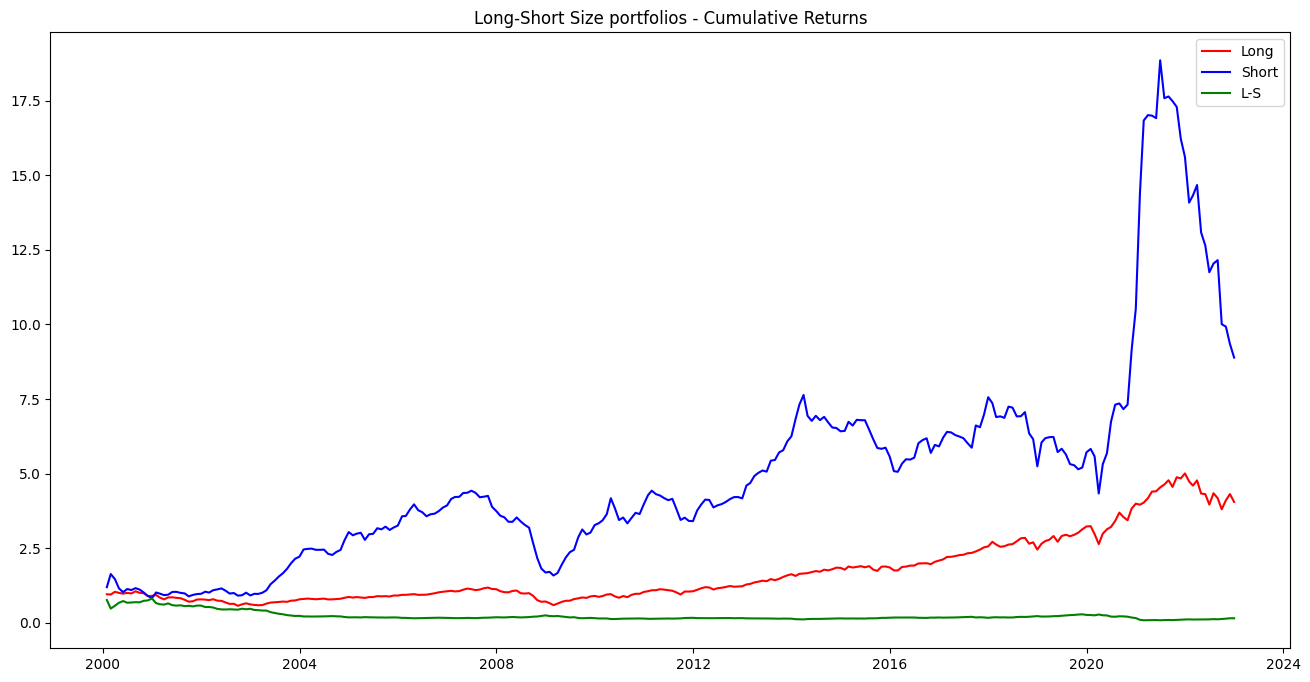

In [38]:
vwret_me_post2000 = vwret_me[vwret_me['date'].dt.year>=2000]
me_long = vwret_me_post2000[vwret_me_post2000['me_decile']==9]['vwret'].reset_index(drop=True)
me_short = vwret_me_post2000[vwret_me_post2000['me_decile']==0]['vwret'].reset_index(drop=True)
plt.figure(figsize=(16,8))
plt.title('Long-Short Size portfolios - Cumulative Returns')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['date'],(vwret_me_post2000[vwret_me_post2000['me_decile']==9]['vwret']+1).cumprod(),'r-')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['date'],(vwret_me_post2000[vwret_me_post2000['me_decile']==0]['vwret']+1).cumprod(),'b-')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['date'],(me_long- me_short+1).cumprod(),'g-')
plt.legend(("Long","Short","L-S"))
plt.show()

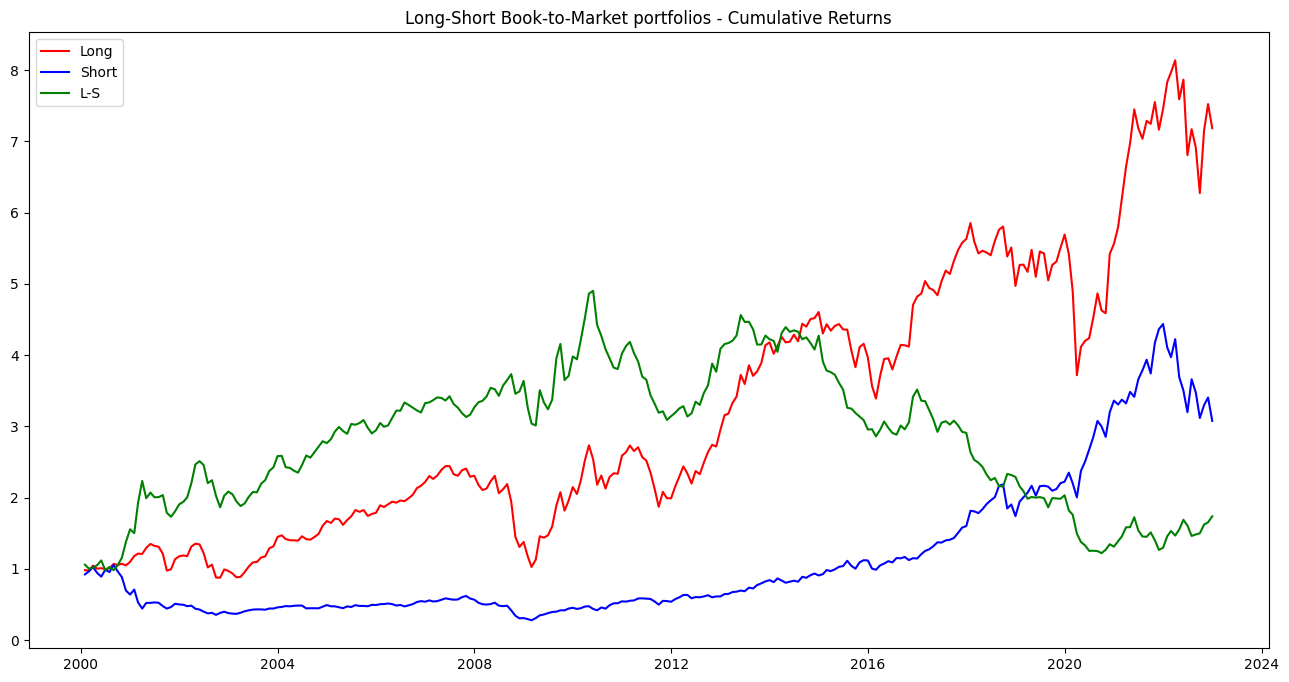

In [39]:
vwret_bm_post2000 = vwret_bm[vwret_bm['date'].dt.year>=2000]
bm_long = vwret_bm_post2000[vwret_bm_post2000['bm_decile']==9]['vwret'].reset_index(drop=True)
bm_short = vwret_bm_post2000[vwret_bm_post2000['bm_decile']==0]['vwret'].reset_index(drop=True)
plt.figure(figsize=(16,8))
plt.title('Long-Short Book-to-Market portfolios - Cumulative Returns')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['date'],(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==9]['vwret']+1).cumprod(),'r-')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['date'],(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==0]['vwret']+1).cumprod(),'b-')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['date'],(bm_long- bm_short+1).cumprod(),'g-')
plt.legend(("Long","Short","L-S"))
plt.show()

In [44]:
# Import the necessary library
from decimal import Decimal

conn = wrds.Connection(wrds_username='id_wrds') # Replace 'id_wrds' with your actual username
ff3 = conn.get_table(library='ff',table='factors_monthly')
conn.close()

ff3 =ff3[['date','smb','hml']]
# Convert 'date' column in ff3 to datetime64[ns]
ff3['date']= pd.to_datetime(ff3['date']) + pd.offsets.MonthEnd(0)

ff_w_est= pd.merge(ff3, ff_factors[['date','estSMB','estHML']],how='inner',on=['date'])
ff_w_est = ff_w_est.dropna()

# Convert both 'smb' and 'estSMB' columns to float before calculating the correlation
ff_w_est['smb'] = ff_w_est['smb'].astype(float)
ff_w_est['estSMB'] = ff_w_est['estSMB'].astype(float)

# Convert 'hml' and 'estHML' to float as well to ensure consistency
ff_w_est['hml'] = ff_w_est['hml'].astype(float)  # Convert 'hml' to float
ff_w_est['estHML'] = ff_w_est['estHML'].astype(float)  # Convert 'estHML' to float

print("SMB factor correlation: ",stats.pearsonr(ff_w_est['smb'],ff_w_est['estSMB'])[0])
print("HML factor correlation: ",stats.pearsonr(ff_w_est['hml'],ff_w_est['estHML'])[0])

Enter your WRDS username [id_wrds]:mjgarciagomez
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
SMB factor correlation:  0.9938890037211273
HML factor correlation:  0.9792109136655684


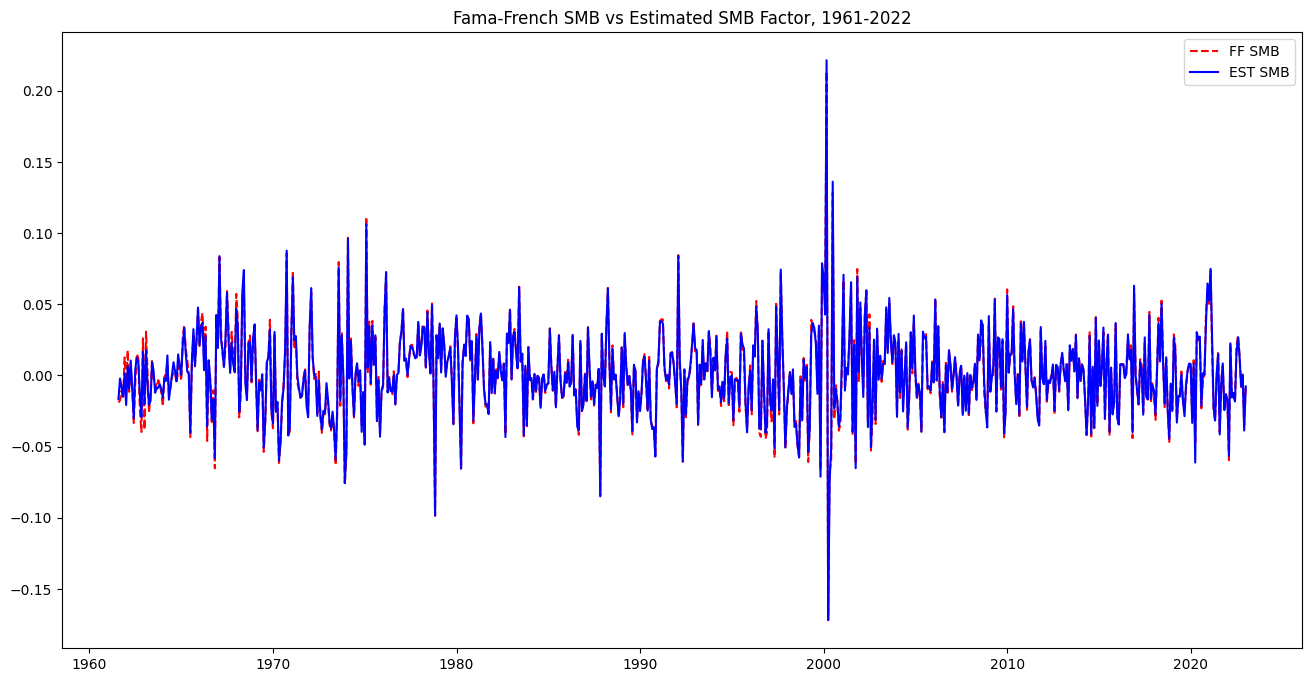

In [45]:
plt.figure(figsize=(16,8))
plt.title('Fama-French SMB vs Estimated SMB Factor, 1961-2022')
plt.plot_date(ff_w_est['date'],ff_w_est['smb'],'r--')
plt.plot_date(ff_w_est['date'],ff_w_est['estSMB'],'b-')
plt.legend(('FF SMB','EST SMB'))

In [46]:
ff_w_est_post72= ff_w_est[ff_w_est['date'].dt.year>=1972]
print("SMB factor correlation: ",stats.pearsonr(ff_w_est_post72['smb'],ff_w_est_post72['estSMB'])[0])
print("HML factor correlation: ",stats.pearsonr(ff_w_est_post72['hml'],ff_w_est_post72['estHML'])[0])

SMB factor correlation:  0.9959450212323541
HML factor correlation:  0.9832693430951367


In [47]:
ff_w_est_post72

,date,smb,hml,estSMB,estHML
126,1972-01-31,0.0585,0.0224,0.061381,0.016020
127,1972-02-29,0.0130,-0.0279,0.012734,-0.026962
128,1972-03-31,-0.0024,-0.0161,-0.000360,-0.022141
129,1972-04-30,0.0011,0.0012,-0.000764,0.005931
130,1972-05-31,-0.0269,-0.0270,-0.028454,-0.022504
...,...,...,...,...,...
733,2022-08-31,0.0140,0.0029,0.012643,0.009274
734,2022-09-30,-0.0082,0.0005,-0.007442,-0.004837
735,2022-10-31,0.0007,0.0802,0.000276,0.079155
736,2022-11-30,-0.0350,0.0138,-0.038698,0.015284


In [48]:
# Calculate volatility (standard deviation)
volatility = np.std(ff_w_est_post72['estSMB'])

# Calculate Sharpe ratio assuming a risk-free rate of 0 (for simplicity)
risk_free_rate = 0.0
mean_returns = np.mean(ff_w_est_post72['estSMB'])
volatility_adjusted_returns = mean_returns - risk_free_rate
sharpe_ratio = volatility_adjusted_returns / volatility

# Calculate skewness
skewness = stats.skew(ff_w_est_post72['estSMB'])

# Print the calculated metrics
print("Volatility: ", volatility)
print("Sharpe ratio: ", sharpe_ratio)
print("Skewness: ", skewness)

Volatility:  0.030342933503129842
Sharpe ratio:  0.04874104953313531
Skewness:  0.5560617316177757


In [49]:
# Calculate volatility (standard deviation)
volatility = np.std(ff_w_est_post72['estHML'])

# Calculate Sharpe ratio assuming a risk-free rate of 0 (for simplicity)
risk_free_rate = 0.0
mean_returns = np.mean(ff_w_est_post72['estHML'])
volatility_adjusted_returns = mean_returns - risk_free_rate
sharpe_ratio = volatility_adjusted_returns / volatility

# Calculate skewness
skewness = stats.skew(ff_w_est_post72['estHML'])

# Print the calculated metrics
print("Volatility: ", volatility)
print("Sharpe ratio: ", sharpe_ratio)
print("Skewness: ", skewness)

Volatility:  0.031141733146937634
Sharpe ratio:  0.09793942853798297
Skewness:  0.0687058525125461
